# Loading Dataset

In [3]:
# libraries for the files in google drive


import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from glob import glob
from sklearn.utils import shuffle
from keras.preprocessing import image
import pickle

In [4]:
import os
print(os.getcwd())

C:\Users\Dream\Downloads\Compressed\NIH sample chest xray


In [5]:
sample = pd.read_csv(r"C:\Users\Dream\Downloads\Compressed\NIH sample chest xray\sample\sample_labels.csv")
sample.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [6]:

# List of diseases
diseases = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Nodule', 'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass', 'Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia']

# Create individual columns for each disease
for disease in diseases:
    sample[disease] = sample['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

# Remove 'Y' after age and convert age to integer
sample['Age'] = sample['Patient Age'].apply(lambda x: x[:-1]).astype(int)
sample['Age Type'] = sample['Patient Age'].apply(lambda x: x[-1:])
sample.loc[sample['Age Type'] == 'M', ['Age']] = sample[sample['Age Type'] == 'M']['Age'].apply(lambda x: round(x / 12.)).astype(int)
sample.loc[sample['Age Type'] == 'D', ['Age']] = sample[sample['Age Type'] == 'D']['Age'].apply(lambda x: round(x / 365.)).astype(int)

# Remove outliers from the 'Age' column
sample = sample.drop(sample['Age'].sort_values(ascending=False).head(1).index)
sample['Age'] = sample['Age'] / sample['Age'].max()

# One-hot encode categorical variables
sample = sample.join(pd.get_dummies(sample['Patient Gender']))
sample = sample.join(pd.get_dummies(sample['View Position']))

# Shuffle the samples
sample = shuffle(sample)

# Get other data
data = sample[['Age', 'F', 'M', 'AP', 'PA']]
data = np.array(data)

labels = sample[diseases].values
files_list = ('C:/Users/Dream/Downloads/Compressed/NIH sample chest xray/sample/images/' + sample['Image Index']).tolist()

labelB = (sample[diseases].sum(axis=1) > 0).tolist()
labelB = np.array(labelB, dtype=int)

In [7]:
def path_to_tensor(img_path, shape):
    # Load RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=shape)
    # Convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img) / 255
    # Convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, shape):
    list_of_tensors = [path_to_tensor(img_path, shape) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

train_labels = labelB[:3400][:, np.newaxis]
valid_labels = labelB[3400:4500][:, np.newaxis]
test_labels = labelB[4500:][:, np.newaxis]

train_data = data[:3400]
valid_data = data[3400:4500]
test_data = data[4500:]

img_shape = (64, 64)
train_tensors = paths_to_tensor(files_list[:3400], shape=img_shape)
valid_tensors = paths_to_tensor(files_list[3400:4500], shape=img_shape)
test_tensors = paths_to_tensor(files_list[4500:], shape=img_shape)

100%|██████████████████████████████████████████████████████████████████████████████| 1105/1105 [00:33<00:00, 33.34it/s]


In [8]:
import os

# Ensure the directory exists
os.makedirs('data_preprocessed', exist_ok=True)

# Save the preprocessed data as pickle files
train_filename = "data_preprocessed/train_data_sample_rgb.p"
pickle.dump((train_labels, train_data, train_tensors), open(train_filename, 'wb'))

valid_filename = "data_preprocessed/valid_data_sample_rgb.p"
pickle.dump((valid_labels, valid_data, valid_tensors), open(valid_filename, 'wb'))

test_filename = "data_preprocessed/test_data_sample_rgb.p"
pickle.dump((test_labels, test_data, test_tensors), open(test_filename, 'wb'))


In [9]:
def path_to_tensor(img_path, shape):
    # Load grayscale image as PIL.Image.Image type
    img = image.load_img(img_path, color_mode='grayscale', target_size=shape)
    # Convert PIL.Image.Image type to 3D tensor with shape (224, 224, 1)
    x = image.img_to_array(img) / 255
    # Convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, shape):
    list_of_tensors = [path_to_tensor(img_path, shape) for img_path in img_paths]
    return np.vstack(list_of_tensors)

train_labels = labelB[:3400][:, np.newaxis]
valid_labels = labelB[3400:4500][:, np.newaxis]
test_labels = labelB[4500:][:, np.newaxis]

train_data = data[:3400]
valid_data = data[3400:4500]
test_data = data[4500:]

img_shape = (64, 64)
train_tensors = paths_to_tensor(files_list[:3400], shape=img_shape)
valid_tensors = paths_to_tensor(files_list[3400:4500], shape=img_shape)
test_tensors = paths_to_tensor(files_list[4500:], shape=img_shape)


In [10]:
# Save the preprocessed grayscale data as pickle files
train_filename = "data_preprocessed/train_data_sample_gray.p"
pickle.dump((train_labels, train_data, train_tensors), open(train_filename, 'wb'))

valid_filename = "data_preprocessed/valid_data_sample_gray.p"
pickle.dump((valid_labels, valid_data, valid_tensors), open(valid_filename, 'wb'))

test_filename = "data_preprocessed/test_data_sample_gray.p"
pickle.dump((test_labels, test_data, test_tensors), open(test_filename, 'wb'))

# Preprocessing and Exploratory Data Analysis
We will separate diseases from 14 diseases and no diseases. Next, transfer the age data to the correct numeric format

In [11]:
diseases = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
#split diseases
for disease in diseases :
    sample[disease] = sample['Finding Labels'].apply(lambda x: 1 if disease in x else 0).astype(int)

sample['No_Finding']=sample['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)
sample['Finding']=sample['Finding Labels'].apply(lambda x: 0 if 'No Finding' in x else 1)

In [12]:
#remove last character in Age
sample['Age']=sample['Patient Age'].apply(lambda x: x[:-1]).astype(int)
sample['Age Type']=sample['Patient Age'].apply(lambda x: x[-1:])

np.unique(sample['Age Type'], return_counts=True)

(array(['D', 'M', 'Y'], dtype=object), array([   1,    1, 5603], dtype=int64))


Seeing that there is an age case is calculated in Day, and one case is in Month, so it's all in Year

In [13]:
sample.loc[sample['Age Type']=='M',['Age']] = sample[sample['Age Type']=='M']['Age'].apply(lambda x: round(x/12.)).astype(int)
sample.loc[sample['Age Type']=='D',['Age']] = sample[sample['Age Type']=='D']['Age'].apply(lambda x: round(x/365.)).astype(int)

In [14]:
sample.describe()

,Follow-up #,Patient ID,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Cardiomegaly,Emphysema,Effusion,Hernia,...,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,Age,No_Finding,Finding
count,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,...,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000
mean,8.617841,14329.444960,2644.722391,2491.077966,0.155470,0.155470,0.025156,0.022658,0.114897,0.002319,...,0.031401,0.050669,0.021053,0.040321,0.172525,0.014987,0.011062,46.702765,0.542908,0.457092
std,15.566953,8411.770419,347.176270,399.154046,0.016201,0.016201,0.156613,0.148825,0.318927,0.048108,...,0.174413,0.219341,0.143573,0.196729,0.377869,0.121510,0.104600,16.720713,0.498200,0.498200
min,0.000000,13.000000,1362.000000,966.000000,0.115000,0.115000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7286.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.000000,0.000000,0.000000
50%,3.000000,13993.000000,2542.000000,2544.000000,0.143000,0.143000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,1.000000,0.000000
75%,10.000000,20654.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000,1.000000,1.000000
max,177.000000,30797.000000,3266.000000,3056.000000,0.198800,0.198800,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,94.000000,1.000000,1.000000


In [15]:
sample['Age'].sort_values(ascending=False).head(20)

3745    94
3573    89
3092    89
1807    89
5403    88
47      87
4998    87
2140    86
681     85
1206    85
5364    85
1737    85
2356    85
189     85
1270    84
600     84
35      84
2428    83
4667    83
5467    83
Name: Age, dtype: int32

<Axes: xlabel='Category', ylabel='count'>

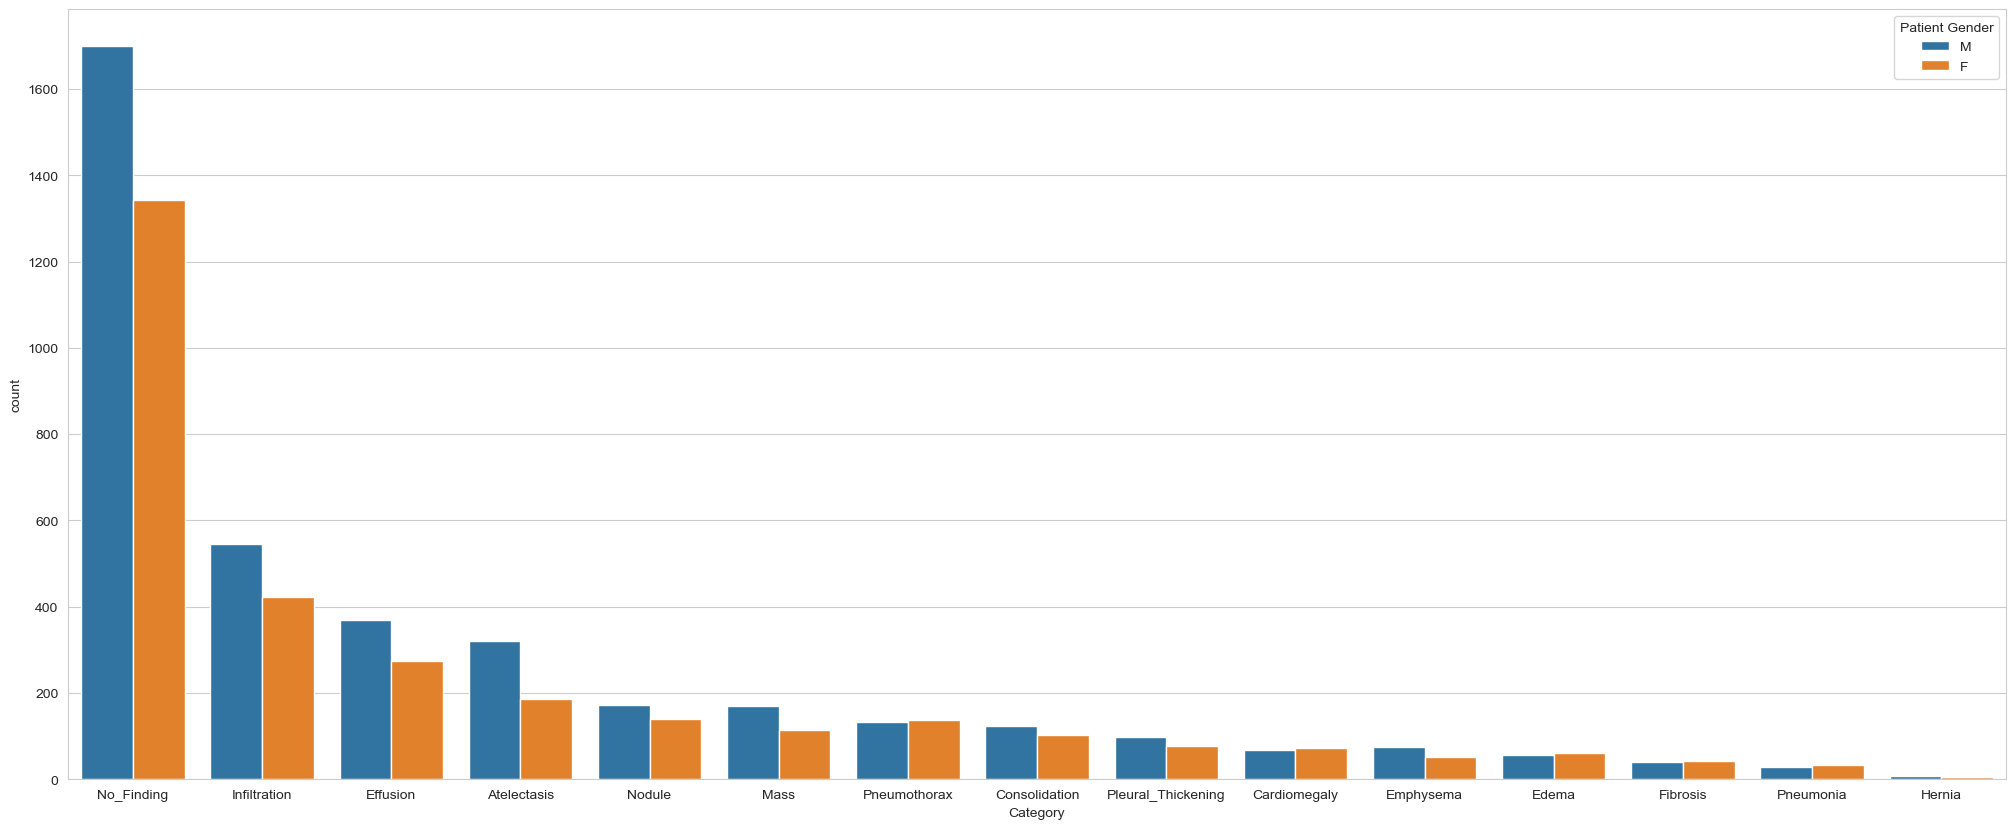

In [16]:
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
ax = plt.subplot()

data = pd.melt(sample, id_vars=['Patient Gender'], value_vars = list(diseases + ['No_Finding']), var_name = 'Category', value_name = 'Count')
data = data.loc[data.Count>0]
sns.countplot(x='Category',hue='Patient Gender',data=data, ax=ax, order = data['Category'].value_counts().index)

Distribution of Patient Gender and Finding diseases

<Axes: xlabel='Category', ylabel='count'>

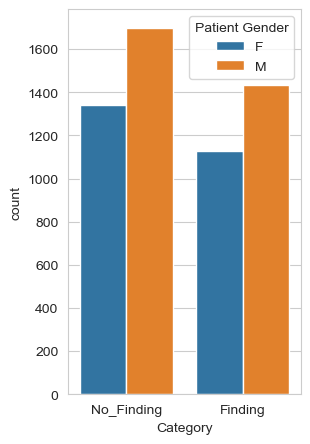

In [17]:
plt.figure(figsize=(3,5))
ax = plt.subplot()

data = pd.melt(sample, id_vars=['Patient Gender'], value_vars = list(['Finding', 'No_Finding']), var_name = 'Category', value_name = 'Count')
data = data.loc[data.Count>0]

sns.countplot(x='Category',hue='Patient Gender',data=data, ax=ax, order = data['Category'].value_counts().index)

C:\Users\Dream\miniconda3\envs\poi\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


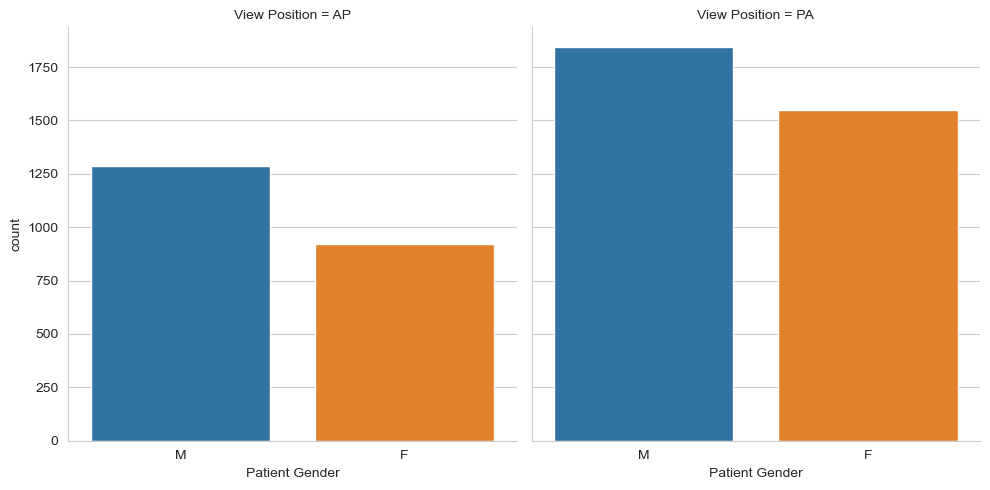

In [18]:
sns.catplot(x="Patient Gender", col="View Position", data=sample, kind="count");

In [19]:
# Different images of view position in same patient

sample[sample['Patient ID'] == 61]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Pneumonia,Age,Age Type,F,M,AP,PA,No_Finding,Finding
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,...,0,0,77,Y,False,True,False,True,0,1
10,00000061_025.png,Consolidation|Effusion|Infiltration|Nodule,25,61,077Y,M,AP,3056,2544,0.139,...,0,0,77,Y,False,True,True,False,0,1
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,...,0,0,77,Y,False,True,True,False,1,0


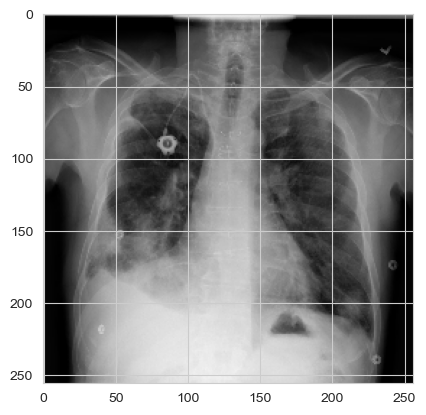

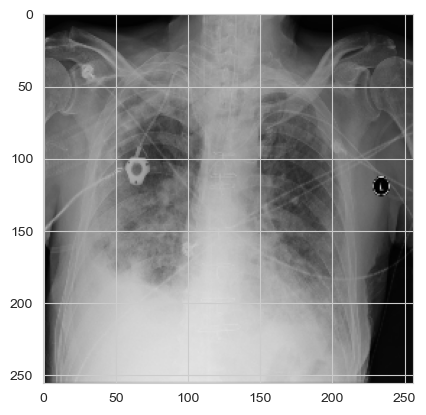

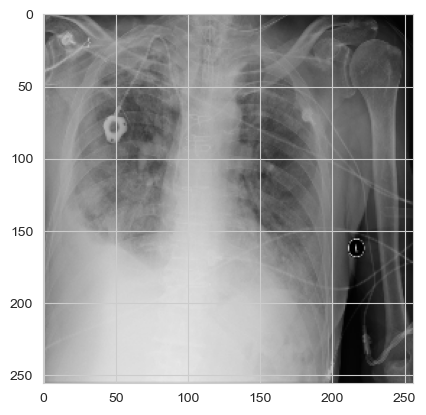

In [20]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

def show_image(img_path):
    image = cv2.imread(img_path)
    if image is not None:
        img = cv2.resize(image, (256, 256))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.show()
    else:
        print(f"Image not found at {img_path}")

# Assuming 'sample' is a DataFrame already defined and loaded
for img_path in sample[sample['Patient ID'] == 61]['Image Index'].tolist():
    full_path = 'C:/Users/Dream/Downloads/Compressed/NIH sample chest xray/sample/images/' + img_path
    show_image(full_path)


C:\Users\Dream\miniconda3\envs\poi\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


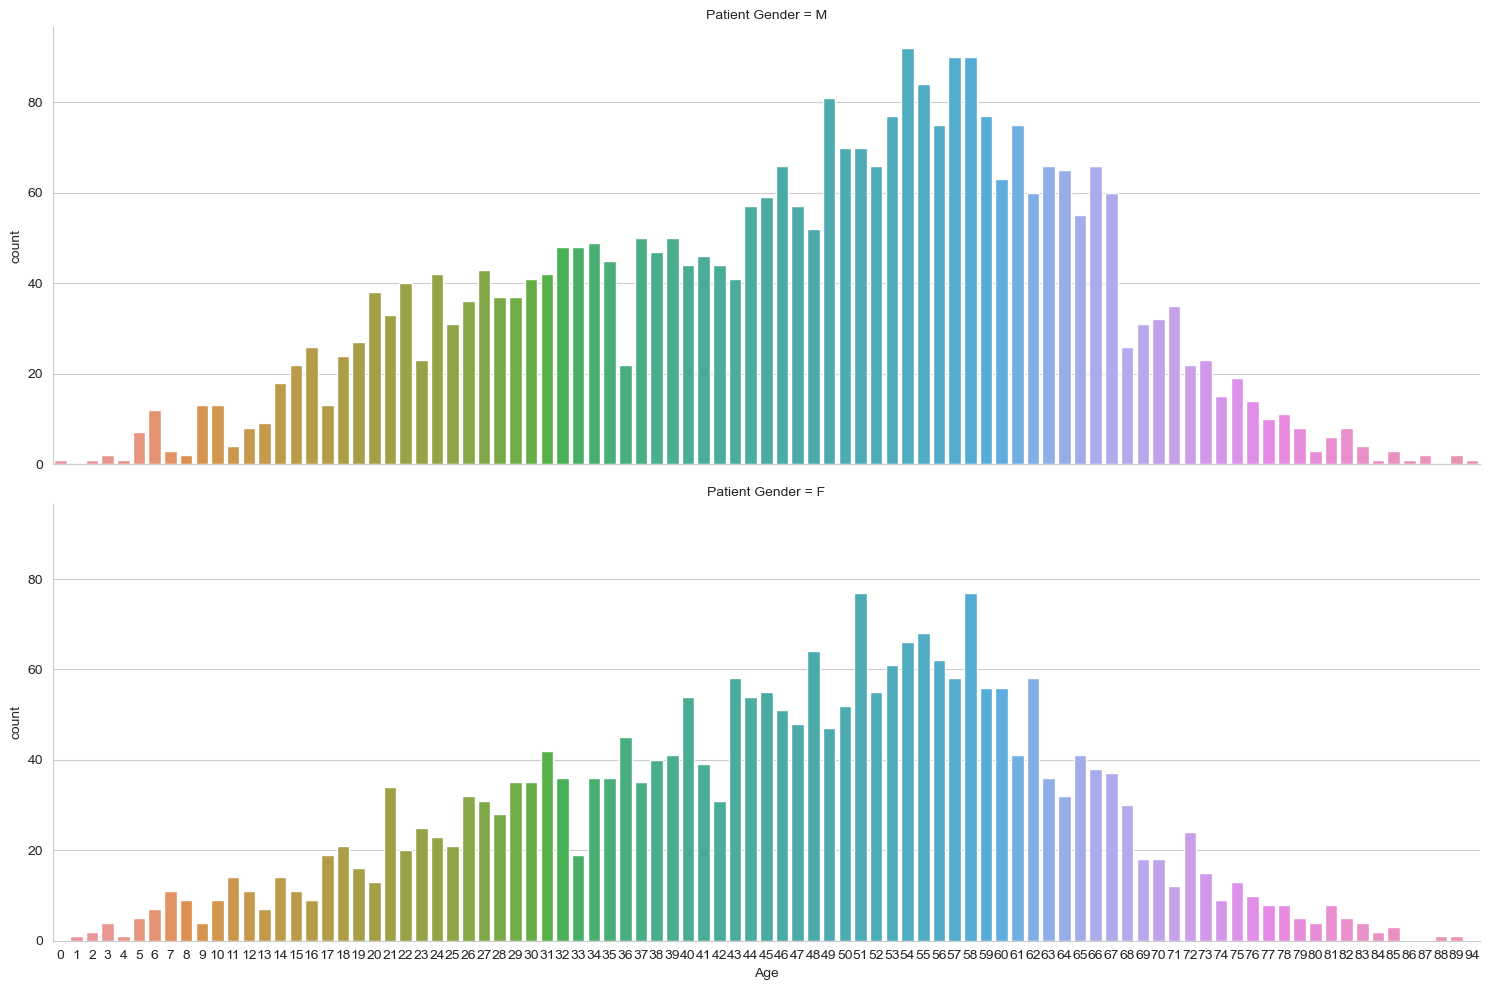

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'sample' is your DataFrame
sns.catplot(x="Age", col="Patient Gender", data=sample, kind="count", height=5, aspect=3, col_wrap=1);

plt.show()  # This ensures the plots are displayed correctly in some environments


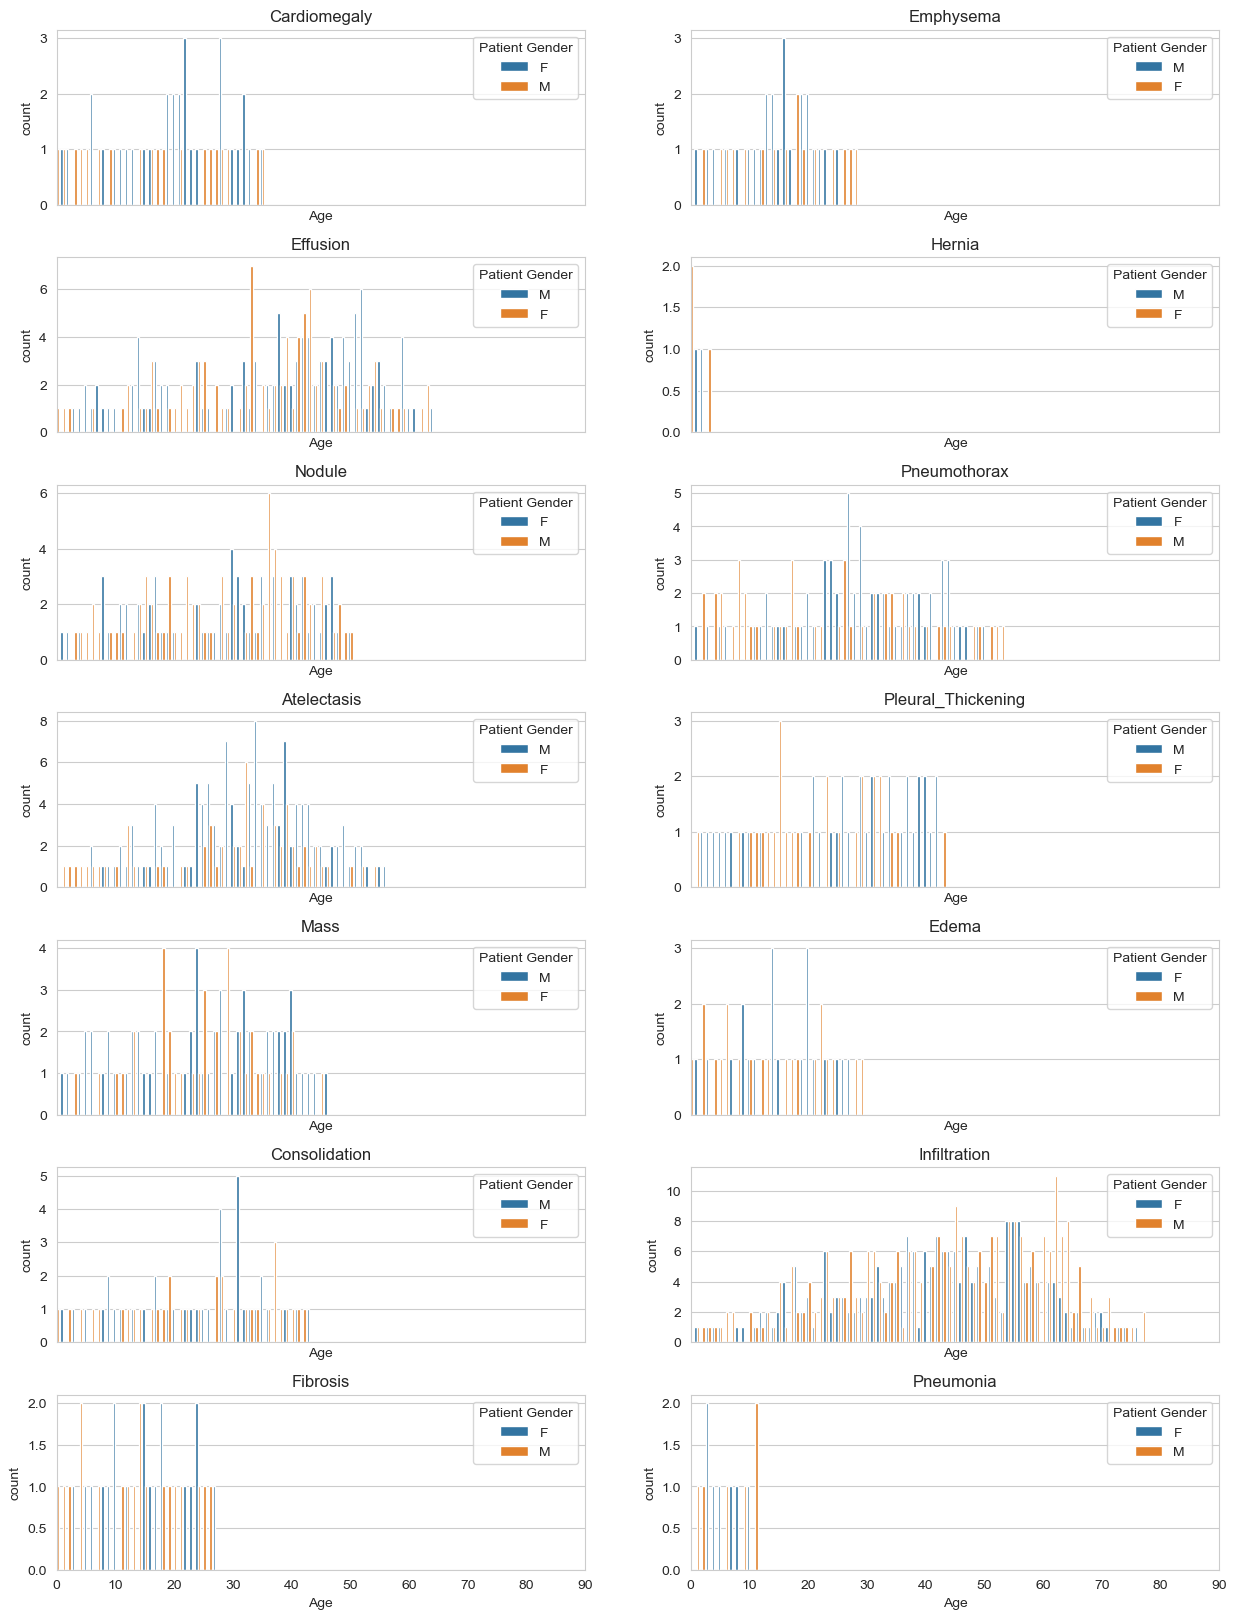

In [22]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))

i=0
j=0
x=np.arange(0,100,10)
for pathology in diseases :
    g=sns.countplot(x='Age', hue="Patient Gender",data=sample[sample['Finding Labels']==pathology], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

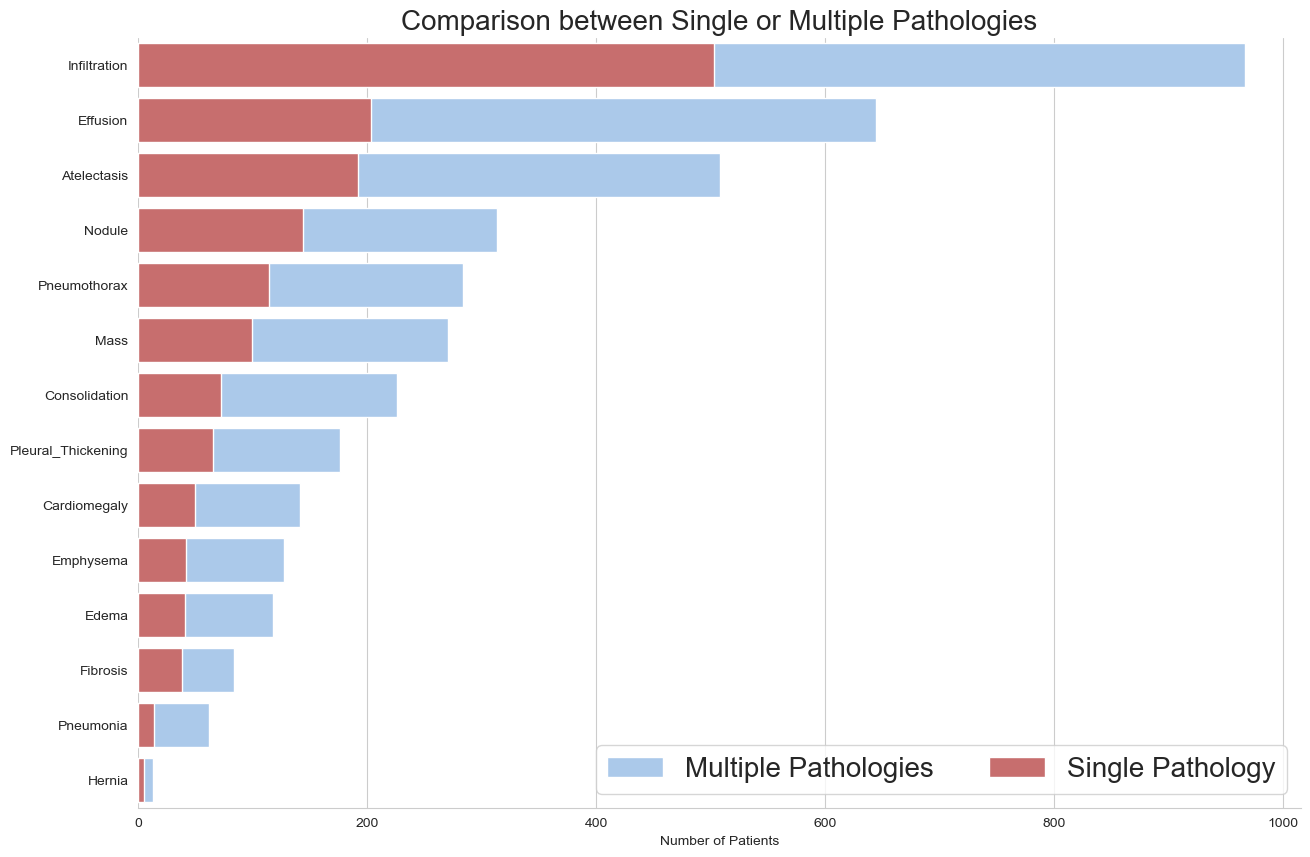

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame and setup (make sure this matches your actual setup)
# Assuming 'sample' is already loaded with data

# Define pathology list before it's used
pathology_list = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Nodule', 'Pneumothorax',
                  'Atelectasis', 'Pleural_Thickening', 'Mass', 'Edema', 'Consolidation',
                  'Infiltration', 'Fibrosis', 'Pneumonia']

# Create pathology flags in the dataframe
for pathology in pathology_list:
    sample[pathology] = sample['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

# Group and prepare data for visualization
data = sample.groupby('Finding Labels').count().sort_values('Patient ID', ascending=False)
df1 = data[[('|' in index) for index in data.index]].copy()
df2 = data[[('|' not in index) for index in data.index]]
df2 = df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels'] = df2.index.values
df1['Finding Labels'] = df1.index.values

# Melt the data for plotting
labels = sample[pathology_list + ['Patient Gender']]  # Ensure this is correctly defined
data1 = pd.melt(sample, id_vars=['Patient Gender'], value_vars=pathology_list,
                var_name='Category', value_name='Count')
data1 = data1[data1['Count'] > 0]

# Prepare figure and axes
f, ax = plt.subplots(figsize=(15, 10))
sns.set_color_codes("pastel")
g = sns.countplot(y='Category', data=data1, ax=ax,
                  order=data1['Category'].value_counts().index, color='b',
                  label="Multiple Pathologies")
sns.set_color_codes("muted")
g = sns.barplot(x='Patient ID', y='Finding Labels', data=df2, ax=ax,
                color="r", label="Single Pathology")

# Set legends and labels
ax.legend(ncol=2, loc="lower right", frameon=True, fontsize=20)
ax.set(ylabel="", xlabel="Number of Patients")
ax.set_title("Comparison between Single or Multiple Pathologies", fontsize=20)
sns.despine(left=True)

plt.show()


# Data Modeling

## Model 1-CNN

In [63]:


train_filename = "data_preprocessed/train_data_sample_rgb.p"
(train_labels, train_data, train_tensors) = pickle.load(open(train_filename, mode='rb'))

valid_filename = "data_preprocessed/valid_data_sample_rgb.p"
(valid_labels, valid_data, valid_tensors) = pickle.load(open(valid_filename, mode='rb'))

test_filename = "data_preprocessed/test_data_sample_rgb.p"
(test_labels, test_data, test_tensors) = pickle.load(open(test_filename, mode='rb'))

In [64]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, applications, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau


tf.keras.backend.clear_session()

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=train_tensors.shape[1:])

#  Define the custom layers
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
add_model.add(Dropout(0.5))
add_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
add_model.add(Dropout(0.5))
add_model.add(Dense(1, activation='sigmoid'))

#  Create the final model
model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

# Model Summary to check architecture
model.summary()



Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 1)                   │       1,180,673 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,895,361 (60.64 MB)

 Trainable params: 15,895,361 (60.64 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
from keras import backend as K
def precision_threshold(threshold=0.5):
    def precision(y_true, y_pred):
        y_pred_thresholded = tf.cast(tf.greater(y_pred, threshold), tf.float32)
        true_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, 1) & tf.equal(y_pred_thresholded, 1), tf.float32))
        predicted_positives = tf.reduce_sum(y_pred_thresholded)
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    return precision

def recall_threshold(threshold=0.5):
    def recall(y_true, y_pred):
        y_pred_thresholded = tf.cast(tf.greater(y_pred, threshold), tf.float32)
        true_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, 1) & tf.equal(y_pred_thresholded, 1), tf.float32))
        possible_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, 1), tf.float32))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    return recall

def fbeta_score_threshold(beta=1, threshold=0.5):
    def fbeta_score(y_true, y_pred):
        p = precision_threshold(threshold)(y_true, y_pred)
        r = recall_threshold(threshold)(y_true, y_pred)
        bb = beta**2
        return (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


In [66]:
# Update for the optimizer to use the `learning_rate` instead of `lr`.
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        precision_threshold(0.4),
        recall_threshold(0.4),
        fbeta_score_threshold(beta=0.5, threshold=0.4),
        precision_threshold(0.5),
        recall_threshold(0.5),
        fbeta_score_threshold(beta=0.5, threshold=0.5),
        precision_threshold(0.6),
        recall_threshold(0.6),
        fbeta_score_threshold(beta=0.5, threshold=0.6)
    ]
)



In [67]:
import os
import tensorflow as tf
epochs = 50
batch_size = 64
# Ensure the save directory exists
os.makedirs('saved_models', exist_ok=True)

# Define the callbacks using TensorFlow's Keras API with the required `.keras` extension
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'saved_models/model.keras',  # Adjusted to use .keras extension as required
    save_best_only=True, 
    monitor='val_loss', 
    mode='min'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True, 
    mode='min'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=5, 
    min_lr=1e-6, 
    mode='min'
)

log = tf.keras.callbacks.CSVLogger('saved_models/training.log')

callbacks = [checkpoint, early_stop, reduce_lr, log]


In [68]:
# Data augmentation parameters are fitting.
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


In [69]:
# Train the model with the timing context inside.
start_time = time.time()

history = model.fit(
    train_datagen.flow(train_tensors, train_labels, batch_size=batch_size),
    steps_per_epoch=len(train_tensors) // batch_size,
    validation_data=(valid_tensors, valid_labels),
    epochs=epochs,
    callbacks=callbacks
)

end_time = time.time()
print(f"Training time: {(end_time - start_time) / 60:.2f} minutes")


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 941ms/step - accuracy: 0.5001 - fbeta_score: 0.4655 - fbeta_score_1: 0.3688 - fbeta_score_2: 0.1893 - loss: 1.6896 - precision: 0.4576 - precision_1: 0.4464 - precision_2: 0.3367 - recall: 0.7005 - recall_1: 0.3564 - recall_2: 0.1417 - val_accuracy: 0.5545 - val_fbeta_score: 0.4978 - val_fbeta_score_1: 0.0000e+00 - val_fbeta_score_2: 0.0000e+00 - val_loss: 1.0686 - val_precision: 0.4435 - val_precision_1: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_recall: 1.0000 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.5156 - fbeta_score: 0.2751 - fbeta_score_1: 0.0653 - fbeta_score_2: 0.0000e+00 - loss: 1.0709 - precision: 0.2468 - precision_1: 0.2547 - precision_2: 0.0000e+00 - recall: 0.5094 - recall_1: 0.0164 - recall_2: 0.0000e+00 - val_accuracy: 0.5545 - val_fbeta_score: 0.4978 - val_fbeta_score_1: 0.0000e+00 - val_fbeta_score_2: 0.0000e+00 - val_los

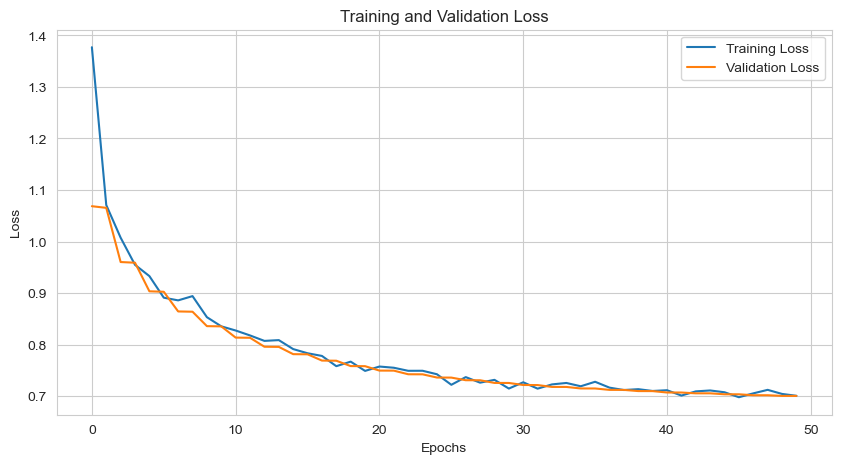

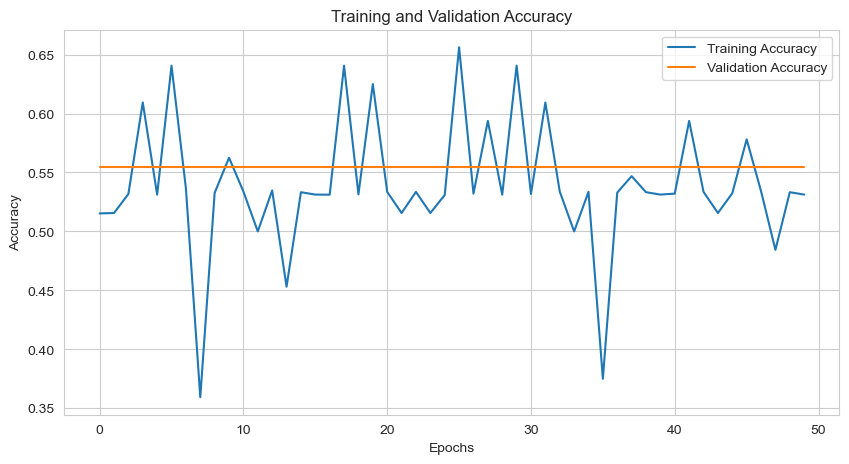

In [70]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [71]:
import types

test_results = model.evaluate(test_tensors, test_labels)
test_loss = test_results[0]
test_acc = test_results[1]
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Print additional metrics
metric_names = [m.__name__ if isinstance(m, types.FunctionType) else m for m in model.metrics]
for metric, value in zip(metric_names[2:], test_results[2:]):
    print(f"Test {metric}: {value:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.5699 - fbeta_score: 0.4840 - fbeta_score_1: 0.0000e+00 - fbeta_score_2: 0.0000e+00 - loss: 0.6984 - precision: 0.4302 - precision_1: 0.0000e+00 - precision_2: 0.0000e+00 - recall: 1.0000 - recall_1: 0.0000e+00 - recall_2: 0.0000e+00
Test loss: 0.6996
Test accuracy: 0.5611


##  Model 2-CNN V2 (Function Parameters Changed)

In [72]:
train_filename = "data_preprocessed/train_data_sample_rgb.p"
valid_filename = "data_preprocessed/valid_data_sample_rgb.p"
test_filename = "data_preprocessed/test_data_sample_rgb.p"

(train_labels_v2, train_data_v2, train_tensors_v2) = pickle.load(open(train_filename, mode='rb'))
(valid_labels_v2, valid_data_v2, valid_tensors_v2) = pickle.load(open(valid_filename, mode='rb'))
(test_labels_v2, test_data_v2, test_tensors_v2) = pickle.load(open(test_filename, mode='rb'))

In [73]:
tf.keras.backend.clear_session()
# Cell 3: Define the base model (VGG16)
base_model_v2 = applications.VGG16(weights='imagenet', include_top=False, input_shape=train_tensors_v2.shape[1:])

# Cell 4: Define the custom layers
add_model_v2 = Sequential()
add_model_v2.add(Flatten(input_shape=base_model_v2.output_shape[1:]))
add_model_v2.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
add_model_v2.add(Dropout(0.5))
add_model_v2.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
add_model_v2.add(Dropout(0.5))
add_model_v2.add(Dense(1, activation='sigmoid'))

# Cell 5: Create the final model
model_v2 = Model(inputs=base_model_v2.input, outputs=add_model_v2(base_model_v2.output))

In [74]:
model_v2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 1)                   │       1,180,673 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,895,361 (60.64 MB)

 Trainable params: 15,895,361 (60.64 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
optimizer = optimizers.Adam(learning_rate=1e-4)
model_v2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [76]:
epochs_v2 = 50
batch_size_v2 = 64

# Ensure the save directory exists
os.makedirs('saved_models', exist_ok=True)

# Define the callbacks using TensorFlow's Keras API with the required `.keras` extension
checkpoint_v2 = tf.keras.callbacks.ModelCheckpoint(
    'saved_models/model_v2.keras',  # Adjusted to use .keras extension as required
    save_best_only=True, 
    monitor='val_loss', 
    mode='min'
)

early_stop_v2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True, 
    mode='min'
)

reduce_lr_v2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=5, 
    min_lr=1e-6, 
    mode='min'
)

log_v2 = tf.keras.callbacks.CSVLogger('saved_models/training_v2.log')

callbacks_v2 = [checkpoint_v2, early_stop_v2, reduce_lr_v2, log_v2]

In [77]:
train_datagen_v2 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

In [82]:
# Train the model with data augmentation and fine-tune the entire model
start_time_v2 = time.time()

# Compile the model before training
model_v2.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_v2 = model_v2.fit(
    train_datagen_v2.flow(train_tensors_v2, train_labels_v2, batch_size=batch_size_v2),
    steps_per_epoch=len(train_tensors_v2) // batch_size_v2,
    validation_data=(valid_tensors_v2, valid_labels_v2),
    epochs=epochs_v2,
    callbacks=callbacks_v2
)

# Fine-tune the entire model
for layer in model_v2.layers:
    layer.trainable = True

model_v2.compile(optimizer=optimizers.SGD(learning_rate=1e-5, momentum=0.9),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_v2_fine_tuned = model_v2.fit(
    train_datagen_v2.flow(train_tensors_v2, train_labels_v2, batch_size=batch_size_v2),
    steps_per_epoch=len(train_tensors_v2) // batch_size_v2,
    validation_data=(valid_tensors_v2, valid_labels_v2),
    epochs=10,
    callbacks=callbacks_v2
)

end_time_v2 = time.time()
print(f"Training time: {(end_time_v2 - start_time_v2) / 60:.2f} minutes")



Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 99s 915ms/step - accuracy: 0.5489 - loss: 0.7561 - val_accuracy: 0.5545 - val_loss: 0.7376 - learning_rate: 1.0000e-04
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.3750 - loss: 0.7609 - val_accuracy: 0.5545 - val_loss: 0.7372 - learning_rate: 1.0000e-04
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 52s 967ms/step - accuracy: 0.5358 - loss: 0.7352 - val_accuracy: 0.5545 - val_loss: 0.7223 - learning_rate: 1.0000e-04
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.4062 - loss: 0.7422 - val_accuracy: 0.5545 - val_loss: 0.7221 - learning_rate: 1.0000e-04
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 53s 987ms/step - accuracy: 0.5384 - loss: 0.7213 - val_accuracy: 0.5545 - val_loss: 0.7123 - learning_rate: 1.0000e-04
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.5000 - loss: 0.7197 - val_accuracy: 0.5545 - val_loss: 0.7122 - learning_rate: 1.0000e-04
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy:

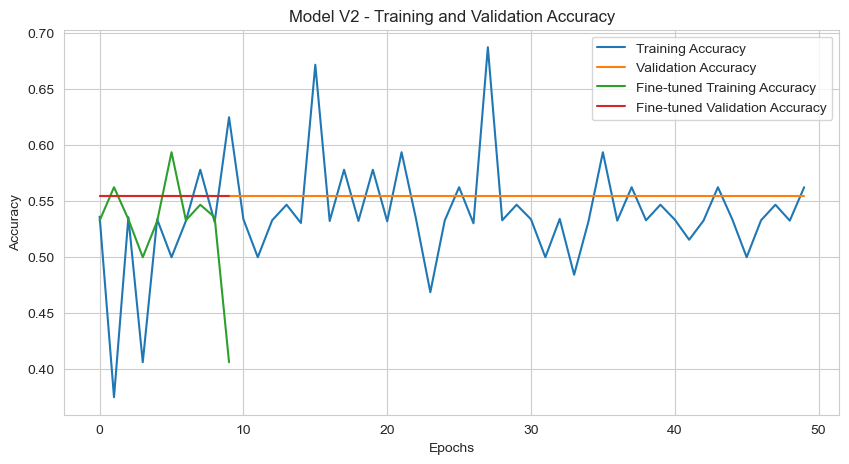

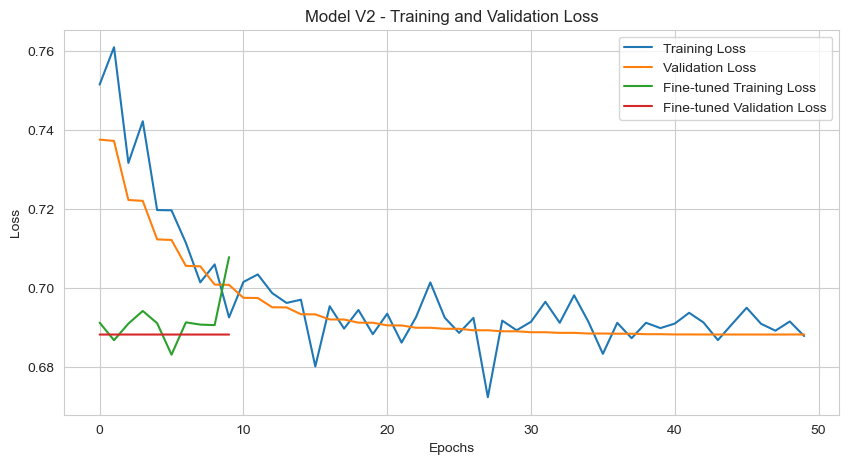

In [84]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_v2.history['accuracy'], label='Training Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_v2_fine_tuned.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_v2_fine_tuned.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model V2 - Training and Validation Accuracy')
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_v2.history['loss'], label='Training Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.plot(history_v2_fine_tuned.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_v2_fine_tuned.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model V2 - Training and Validation Loss')
plt.show()

In [85]:
# Cell 11: Evaluate the model on the test set
test_loss_v2, test_acc_v2 = model_v2.evaluate(test_tensors_v2, test_labels_v2)
print(f"Test accuracy: {test_acc_v2:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.5699 - loss: 0.6862
Test accuracy: 0.5611


In [119]:
model_v2.load_weights('saved_models/model_v2.keras')
prediction_v2 = model_v2.predict(test_tensors_v2)

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step


In [122]:
from sklearn.metrics import accuracy_score

# Convert the predictions to binary labels based on the threshold
predicted_labels = (prediction_v2 > threshold).astype(int)

# Calculate binary accuracy using sklearn metrics
binary_acc = accuracy_score(test_labels_v2, predicted_labels)

print("Binary Accuracy: {:.4f}".format(binary_acc))

Binary Accuracy: 0.5665


## Model 3-EfficientNetB7

In [86]:
import pickle
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [87]:
# Cell 2: Define the create_model_efficientnetb7 function
def create_model_efficientnetb7(input_shape, num_classes):
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

In [88]:
# Cell 3: Load data
train_filename = "data_preprocessed/train_data_sample_rgb.p"
(train_labels_efficientnetb7, train_data_efficientnetb7, train_tensors_efficientnetb7) = pickle.load(open(train_filename, mode='rb'))

valid_filename = "data_preprocessed/valid_data_sample_rgb.p"
(valid_labels_efficientnetb7, valid_data_efficientnetb7, valid_tensors_efficientnetb7) = pickle.load(open(valid_filename, mode='rb'))

test_filename = "data_preprocessed/test_data_sample_rgb.p"
(test_labels_efficientnetb7, test_data_efficientnetb7, test_tensors_efficientnetb7) = pickle.load(open(test_filename, mode='rb'))

In [89]:
# Cell 4: Set hyperparameters
input_shape_efficientnetb7 = train_tensors_efficientnetb7.shape[1:]
num_classes_efficientnetb7 = 1  # Binary classification
batch_size_efficientnetb7 = 32  # Increased batch size for better performance
epochs_efficientnetb7 = 50
learning_rate_efficientnetb7 = 1e-4

In [90]:
# Cell 5: Create model
model_efficientnetb7 = create_model_efficientnetb7(input_shape_efficientnetb7, num_classes_efficientnetb7)

In [91]:
model_efficientnetb7.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 64, 64, 3)         │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 64, 64, 3)         │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 64, 64, 3)         │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 65, 65, 3)         │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 32, 32, 64)        │           1,728 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 32, 32, 64)        │             256 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 32, 32, 64)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 32, 32, 64)        │             576 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 32, 32, 64)        │             256 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 32, 32, 64)        │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 64)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 64)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 16)          │           1,040 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 64)          │           1,088 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 66,721,176 (254.52 MB)

 Trainable params: 66,410,449 (253.34 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [92]:
# Cell 6: Compile model
optimizer_efficientnetb7 = Adam(learning_rate=learning_rate_efficientnetb7)
model_efficientnetb7.compile(optimizer=optimizer_efficientnetb7, loss='binary_crossentropy', metrics=['accuracy'])

In [93]:

# Cell 7: Define data augmentation
train_datagen_efficientnetb7 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen_efficientnetb7 = ImageDataGenerator()

In [95]:

# Cell 8: Define model checkpoint callback
checkpoint_efficientnetb7 = ModelCheckpoint(
    'saved_models/model_efficientnetb7.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

In [96]:
# Cell 9: Train the model
history_efficientnetb7 = model_efficientnetb7.fit(
    train_datagen_efficientnetb7.flow(train_tensors_efficientnetb7, train_labels_efficientnetb7, batch_size=batch_size_efficientnetb7),
    steps_per_epoch=len(train_tensors_efficientnetb7) // batch_size_efficientnetb7,
    validation_data=valid_datagen_efficientnetb7.flow(valid_tensors_efficientnetb7, valid_labels_efficientnetb7),
    validation_steps=len(valid_tensors_efficientnetb7) // batch_size_efficientnetb7,
    epochs=epochs_efficientnetb7,
    callbacks=[checkpoint_efficientnetb7]
)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 639s 4s/step - accuracy: 0.5386 - loss: 0.6978 - val_accuracy: 0.5551 - val_loss: 0.6870
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 22s 184ms/step - accuracy: 0.4688 - loss: 0.8135 - val_accuracy: 0.5000 - val_loss: 0.7028
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.6169 - loss: 0.6730 - val_accuracy: 0.5184 - val_loss: 0.6953
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5938 - loss: 0.6469 - val_accuracy: 0.5000 - val_loss: 0.7051
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.6164 - loss: 0.6549 - val_accuracy: 0.4467 - val_loss: 0.8217
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5938 - loss: 0.7382 - val_accuracy: 0.4167 - val_loss: 0.9013
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.6405 - loss: 0.6477 - val_accuracy: 0.4825 - val_loss: 1.0359
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6250 - loss: 0.6621 - val_acc

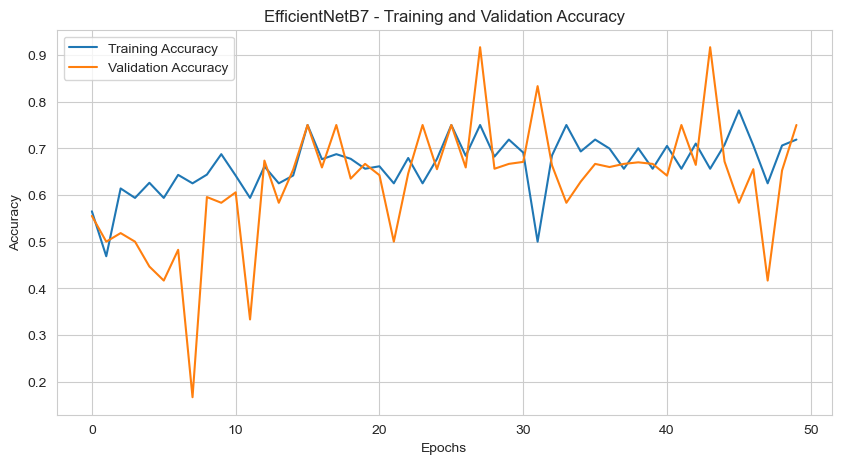

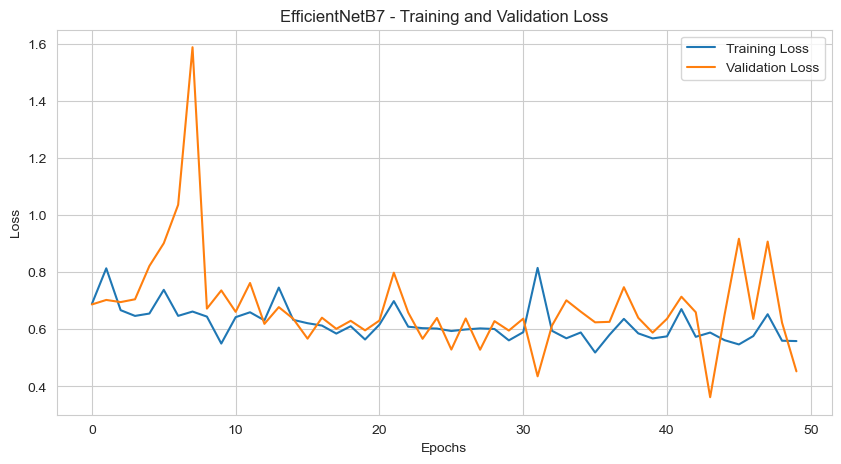

In [97]:
# Cell 10: Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_efficientnetb7.history['accuracy'], label='Training Accuracy')
plt.plot(history_efficientnetb7.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('EfficientNetB7 - Training and Validation Accuracy')
plt.show()

# Cell 11: Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_efficientnetb7.history['loss'], label='Training Loss')
plt.plot(history_efficientnetb7.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('EfficientNetB7 - Training and Validation Loss')
plt.show()

In [98]:
# Cell 12: Evaluate the EfficientNetB7 model on the test set
test_loss_efficientnetb7, test_acc_efficientnetb7 = model_efficientnetb7.evaluate(test_tensors_efficientnetb7, test_labels_efficientnetb7)
print(f"Test accuracy (EfficientNetB7): {test_acc_efficientnetb7:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6672 - loss: 0.6552
Test accuracy (EfficientNetB7): 0.6507
